# Kelvin-Helmholtz Instability

With the Kelvin-Helmholtz test, we evaluate the ability of the code to model the shear flow of two different fluid layers with different densities. In particular, we establish two layers flowing in opposite directions and induce a velocity perturbation perpendicular to the interface between the two layers – modeling the growth of this perturbation is the Kelvin-Helmholtz test. 

Specifically, we construct a periodic box of unit side length and introduce a density profile as follows:
$$
\rho =   \left\{
\begin{array}{ll}
      2 & y< 0.25 \\
      1 & 0.25 \leq y \leq 0.75 \\
      2 & y > 0.75 \\
\end{array} 
\right.  
$$
We set these two layers of fluid to flow in opposite directions:
$$
v_x =   \left\{
\begin{array}{ll}
      -0.5 & y< 0.25 \\
      0.5 & 0.25 \leq y \leq 0.75 \\
      -0.5 & y > 0.75 \\
\end{array} 
\right.  
$$
Finally, we perturb the fluid slightly with a vertical component to the velocity:
$$v_y(x,y) = \omega_0 \sin(4\pi x)\Bigg(\exp\Bigg(-\frac{(y-0.25)^2}{2\sigma^2}\Bigg)+\exp\Bigg(-\frac{(y-0.75)^2}{2\sigma^2}\Bigg)\Bigg)$$
so very close to the interfaces between the layers (given by the terms in the exponential, $\sigma = 0.05/\sqrt{2}$), we introduce a sinusoidally varying perturbation, whose amplitude is $\omega_0 = 0.1$. We establish a uniform pressure profile for the two layers and evolve the simulation to $t = 2$. As before, the initial setup is wrapped in the ``create_particles`` method. 

In [1]:
import phd
import numpy as np

In [2]:
def create_particles(dim, gamma, units = "cgs"):

    Lx = 1.    # domain size in x
    nx = 50   # particles per dim
    n = nx*nx  # number of points

    rho_1 = 1.0; rho_2 = 2.0
    vel = 0.5; amp = 0.05
    sigma=0.05/np.sqrt(2)

    dx = Lx/nx # spacing between particles

    # create particle container
    particles, units = phd.HydroParticleCreator(n, dim=2, unit_sys = units)
    part = 0
    for i in range(nx):
        for j in range(nx):

            x = (i+0.5)*dx
            y = (j+0.5)*dx

            pert = amp*np.sin(4.*np.pi*x)

            if 0.25 < y and y < 0.75:
                particles["density"][part] = rho_2
                particles["velocity-x"][part] = vel

            else:
                particles["density"][part] = rho_1
                particles["velocity-x"][part] = -vel


            particles["velocity-y"][part] = 0.1*np.sin(4*np.pi*x)*(np.exp(-(y-0.25)**2/(2*sigma**2)) +\
                    np.exp(-(y-0.75)**2/(2*sigma**2)))
            particles["position-x"][part] = x
            particles["position-y"][part] = y
            particles["ids"][part] = part
            part += 1

    particles["pressure"][:] = 2.5

    return particles, units

In [3]:
dim = 2; gamma = 5./3.
particles, units = phd.distribute_initial_particles(
                    create_particles, dim=dim, gamma=gamma, units = "cgs")

# computation related to boundaries
domain_manager = phd.DomainManager(
        xmin=[0., 0.], xmax=[1., 1.], initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh()

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Periodic())
integrator.set_reconstruction(phd.PieceWiseLinear())
integrator.set_equation_state(phd.IdealGas(gamma=gamma))
integrator.set_units(units)

sim_name = "kelvin"
if phd._in_parallel:
    integrator.set_load_balance(phd.LoadBalance())
    sim_name = "mpi_kelvin"

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=2.0))

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output every 0.1 time interval
output = phd.TimeInterval(time_interval=0.1)
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# Create simulator
simulation = phd.Simulation(simulation_name=sim_name)
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [INFO     ] 2021-06-02 12:24:18,197: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: kelvin.log
Problem solving: kelvin
Output data will be saved at: kelvin_output

Classes used in the simulation
------------------------------
boundary_condition: Periodic
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh
particles: CarrayContainer
reconstruction: PieceWiseLinear
riemann: HLLC

phd: [INFO     ] 2021-06-02 12:24:18,200: IntegrateBase: Building initial mesh
phd: [INFO     ] 2021-06-02 12:24:18,200: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:18,235: Beginning integration loop
phd: [INFO     ] 2021-06-02 12:24:18,237: Hydro dt: 0.002764
phd: [INFO     ] 2021-06-02 12:24:18,237: Sta

phd: [INFO     ] 2021-06-02 12:24:18,680: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:18,682: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:18,704: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:18,720: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:18,727: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:18,745: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:18,771: Hydro dt: 0.002711
phd: [INFO     ] 2021-06-02 12:24:18,780: Starting iteration: 11 time: 0.030013 dt: 0.002711
phd: [INFO     ] 2021-06-02 12:24:18,782: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:18,801: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:18,810: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:18,812: PieceWiseLinear: Starting temporal reconstru

phd: [INFO     ] 2021-06-02 12:24:19,255: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:19,256: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:19,258: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:19,282: Hydro dt: 0.002726
phd: [INFO     ] 2021-06-02 12:24:19,282: Starting iteration: 22 time: 0.059914 dt: 0.002726
phd: [INFO     ] 2021-06-02 12:24:19,283: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:19,285: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:19,293: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:19,295: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:19,296: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:19,297: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:19,321: Hydro dt: 0.002727
phd: [INFO     ] 2021-06-02 12:24:19,322: Starting iteration: 2

phd: [INFO     ] 2021-06-02 12:24:19,751: Starting iteration: 33 time: 0.089941 dt: 0.002731
phd: [INFO     ] 2021-06-02 12:24:19,751: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:19,753: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:19,763: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:19,765: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:19,766: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:19,767: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:19,792: Hydro dt: 0.002730
phd: [INFO     ] 2021-06-02 12:24:19,793: Starting iteration: 34 time: 0.092672 dt: 0.002730
phd: [INFO     ] 2021-06-02 12:24:19,793: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:19,796: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:19,804: PieceWiseLinear: Starting spatial reconstr

phd: [INFO     ] 2021-06-02 12:24:20,203: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:20,211: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:20,213: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:20,214: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:20,215: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:20,239: Hydro dt: 0.002720
phd: [INFO     ] 2021-06-02 12:24:20,240: Starting iteration: 45 time: 0.121812 dt: 0.002720
phd: [INFO     ] 2021-06-02 12:24:20,240: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:20,242: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:20,250: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:20,252: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:20,253: HLLC: Starting riemann
phd: [INFO     ]

phd: [INFO     ] 2021-06-02 12:24:20,671: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:20,673: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:20,697: Hydro dt: 0.002716
phd: [INFO     ] 2021-06-02 12:24:20,697: Starting iteration: 56 time: 0.151631 dt: 0.002716
phd: [INFO     ] 2021-06-02 12:24:20,698: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:20,700: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:20,707: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:20,709: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:20,710: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:20,712: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:20,736: Hydro dt: 0.002720
phd: [INFO     ] 2021-06-02 12:24:20,737: Starting iteration: 57 time: 0.154347 dt: 0.002720
phd: [INFO     ] 2021-06-02 12:24:20,737: MovingMeshMUSCLHanco

phd: [INFO     ] 2021-06-02 12:24:21,146: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:21,148: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:21,156: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,158: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,159: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:21,161: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:21,184: Hydro dt: 0.002731
phd: [INFO     ] 2021-06-02 12:24:21,185: Starting iteration: 68 time: 0.184403 dt: 0.002731
phd: [INFO     ] 2021-06-02 12:24:21,185: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:21,187: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:21,195: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,197: PieceWiseLinear: Starting temporal reconstru

phd: [INFO     ] 2021-06-02 12:24:21,616: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,618: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,619: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:21,621: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:21,645: Hydro dt: 0.002722
phd: [INFO     ] 2021-06-02 12:24:21,645: Starting iteration: 79 time: 0.213608 dt: 0.002722
phd: [INFO     ] 2021-06-02 12:24:21,646: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:21,648: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:21,655: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,657: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:21,659: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:21,661: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24

phd: [INFO     ] 2021-06-02 12:24:22,079: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:22,104: Hydro dt: 0.002733
phd: [INFO     ] 2021-06-02 12:24:22,104: Starting iteration: 90 time: 0.243614 dt: 0.002733
phd: [INFO     ] 2021-06-02 12:24:22,104: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:22,106: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:22,114: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:22,116: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:22,117: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:22,119: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:22,143: Hydro dt: 0.002731
phd: [INFO     ] 2021-06-02 12:24:22,143: Starting iteration: 91 time: 0.246347 dt: 0.002731
phd: [INFO     ] 2021-06-02 12:24:22,144: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:22,146

phd: [INFO     ] 2021-06-02 12:24:22,556: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:22,564: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:22,566: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:22,567: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:22,569: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:22,593: Hydro dt: 0.002724
phd: [INFO     ] 2021-06-02 12:24:22,593: Starting iteration: 102 time: 0.276356 dt: 0.002724
phd: [INFO     ] 2021-06-02 12:24:22,594: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:22,596: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:22,603: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:22,605: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:22,606: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:23,010: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,012: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:23,013: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:23,037: Hydro dt: 0.002705
phd: [INFO     ] 2021-06-02 12:24:23,038: Starting iteration: 113 time: 0.305428 dt: 0.002705
phd: [INFO     ] 2021-06-02 12:24:23,038: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:23,040: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:23,049: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,050: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,051: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:23,053: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:23,077: Hydro dt: 0.002702
phd: [INFO     ] 2021-06-02 12:24:23,078: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:23,471: Starting iteration: 124 time: 0.335097 dt: 0.002682
phd: [INFO     ] 2021-06-02 12:24:23,471: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:23,473: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:23,481: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,483: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,484: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:23,486: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:23,510: Hydro dt: 0.002681
phd: [INFO     ] 2021-06-02 12:24:23,511: Starting iteration: 125 time: 0.337779 dt: 0.002681
phd: [INFO     ] 2021-06-02 12:24:23,511: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:23,513: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:23,521: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:23,940: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,941: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,943: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:23,945: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:23,968: Hydro dt: 0.002673
phd: [INFO     ] 2021-06-02 12:24:23,969: Starting iteration: 136 time: 0.367294 dt: 0.002673
phd: [INFO     ] 2021-06-02 12:24:23,969: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:23,971: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:23,980: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,982: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:23,983: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:23,984: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:24,428: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:24,456: Hydro dt: 0.002664
phd: [INFO     ] 2021-06-02 12:24:24,457: Starting iteration: 147 time: 0.396627 dt: 0.002664
phd: [INFO     ] 2021-06-02 12:24:24,457: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:24,461: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:24,471: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:24,473: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:24,475: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:24,479: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:24,506: Hydro dt: 0.002663
phd: [INFO     ] 2021-06-02 12:24:24,506: Starting iteration: 148 time: 0.399291 dt: 0.000709
phd: [INFO     ] 2021-06-02 12:24:24,507: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:24,5

phd: [INFO     ] 2021-06-02 12:24:24,950: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:24,952: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:24,960: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:24,961: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:24,962: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:24,964: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:24,987: Hydro dt: 0.002627
phd: [INFO     ] 2021-06-02 12:24:24,987: Starting iteration: 159 time: 0.426388 dt: 0.002627
phd: [INFO     ] 2021-06-02 12:24:24,988: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:24,990: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:24,997: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:24,999: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:25,408: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:25,409: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:25,411: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:25,434: Hydro dt: 0.002592
phd: [INFO     ] 2021-06-02 12:24:25,434: Starting iteration: 170 time: 0.455103 dt: 0.002592
phd: [INFO     ] 2021-06-02 12:24:25,435: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:25,436: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:25,444: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:25,446: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:25,447: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:25,449: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:25,473: Hydro dt: 0.002585
phd: [INFO     ] 2021-06-02 12:24:25,474: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:25,984: Starting iteration: 181 time: 0.483293 dt: 0.002549
phd: [INFO     ] 2021-06-02 12:24:25,985: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:25,987: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:25,995: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:25,996: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:25,998: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:26,000: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:26,025: Hydro dt: 0.002539
phd: [INFO     ] 2021-06-02 12:24:26,025: Starting iteration: 182 time: 0.485842 dt: 0.002539
phd: [INFO     ] 2021-06-02 12:24:26,026: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:26,028: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:26,036: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:26,442: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:26,450: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:26,452: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:26,453: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:26,454: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:26,478: Hydro dt: 0.002401
phd: [INFO     ] 2021-06-02 12:24:26,478: Starting iteration: 193 time: 0.512215 dt: 0.002401
phd: [INFO     ] 2021-06-02 12:24:26,479: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:26,480: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:26,488: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:26,490: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:26,491: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:26,903: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:26,905: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:26,932: Hydro dt: 0.002313
phd: [INFO     ] 2021-06-02 12:24:26,932: Starting iteration: 204 time: 0.538068 dt: 0.002313
phd: [INFO     ] 2021-06-02 12:24:26,933: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:26,935: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:26,943: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:26,944: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:26,946: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:26,947: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:26,970: Hydro dt: 0.002369
phd: [INFO     ] 2021-06-02 12:24:26,971: Starting iteration: 205 time: 0.540381 dt: 0.002369
phd: [INFO     ] 2021-06-02 12:24:26,971: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:27,369: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:27,371: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:27,380: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:27,382: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:27,383: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:27,385: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:27,410: Hydro dt: 0.002423
phd: [INFO     ] 2021-06-02 12:24:27,410: Starting iteration: 216 time: 0.566158 dt: 0.002423
phd: [INFO     ] 2021-06-02 12:24:27,411: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:27,413: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:27,420: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:27,423: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:27,830: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:27,832: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:27,835: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:27,860: Hydro dt: 0.002345
phd: [INFO     ] 2021-06-02 12:24:27,861: Starting iteration: 227 time: 0.592659 dt: 0.002345
phd: [INFO     ] 2021-06-02 12:24:27,861: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:27,863: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:27,871: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:27,872: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:27,873: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:27,875: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:27,899: Hydro dt: 0.002341
phd: [INFO     ] 2021-06-02 12:24:27,899: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:28,284: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:28,308: Hydro dt: 0.002469
phd: [INFO     ] 2021-06-02 12:24:28,309: Starting iteration: 238 time: 0.617034 dt: 0.002469
phd: [INFO     ] 2021-06-02 12:24:28,309: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:28,311: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:28,319: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:28,321: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:28,322: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:28,325: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:28,349: Hydro dt: 0.002474
phd: [INFO     ] 2021-06-02 12:24:28,349: Starting iteration: 239 time: 0.619503 dt: 0.002474
phd: [INFO     ] 2021-06-02 12:24:28,350: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:28,3

phd: [INFO     ] 2021-06-02 12:24:28,761: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:28,769: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:28,771: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:28,772: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:28,774: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:28,798: Hydro dt: 0.002441
phd: [INFO     ] 2021-06-02 12:24:28,799: Starting iteration: 250 time: 0.646596 dt: 0.002441
phd: [INFO     ] 2021-06-02 12:24:28,799: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:28,801: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:28,809: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:28,811: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:28,812: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:29,240: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:29,242: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:29,266: Hydro dt: 0.002407
phd: [INFO     ] 2021-06-02 12:24:29,267: Starting iteration: 261 time: 0.673308 dt: 0.002407
phd: [INFO     ] 2021-06-02 12:24:29,267: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:29,269: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:29,277: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:29,279: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:29,280: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:29,282: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:29,305: Hydro dt: 0.002415
phd: [INFO     ] 2021-06-02 12:24:29,306: Starting iteration: 262 time: 0.675716 dt: 0.002415
phd: [INFO     ] 2021-06-02 12:24:29,306: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:29,743: Starting iteration: 272 time: 0.700000 dt: 0.002410
phd: [INFO     ] 2021-06-02 12:24:29,743: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:29,745: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:29,753: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:29,754: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:29,756: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:29,757: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:29,782: Hydro dt: 0.002453
phd: [INFO     ] 2021-06-02 12:24:29,782: Starting iteration: 273 time: 0.702410 dt: 0.002453
phd: [INFO     ] 2021-06-02 12:24:29,782: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:29,784: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:29,792: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:30,219: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:30,221: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:30,222: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:30,224: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:30,248: Hydro dt: 0.002418
phd: [INFO     ] 2021-06-02 12:24:30,249: Starting iteration: 284 time: 0.729283 dt: 0.002418
phd: [INFO     ] 2021-06-02 12:24:30,249: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:30,251: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:30,259: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:30,261: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:30,262: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:30,264: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:30,682: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:30,707: Hydro dt: 0.002345
phd: [INFO     ] 2021-06-02 12:24:30,707: Starting iteration: 295 time: 0.755513 dt: 0.002345
phd: [INFO     ] 2021-06-02 12:24:30,708: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:30,710: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:30,718: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:30,719: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:30,721: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:30,722: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:30,747: Hydro dt: 0.002347
phd: [INFO     ] 2021-06-02 12:24:30,747: Starting iteration: 296 time: 0.757858 dt: 0.002347
phd: [INFO     ] 2021-06-02 12:24:30,748: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:30,7

phd: [INFO     ] 2021-06-02 12:24:31,171: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:31,179: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,181: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,182: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:31,183: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:31,207: Hydro dt: 0.002412
phd: [INFO     ] 2021-06-02 12:24:31,208: Starting iteration: 307 time: 0.784172 dt: 0.002412
phd: [INFO     ] 2021-06-02 12:24:31,208: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:31,210: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:31,218: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,220: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,221: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:31,636: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,637: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:31,639: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:31,663: Hydro dt: 0.002428
phd: [INFO     ] 2021-06-02 12:24:31,664: Starting iteration: 318 time: 0.809678 dt: 0.002428
phd: [INFO     ] 2021-06-02 12:24:31,664: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:31,666: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:31,674: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,676: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:31,677: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:31,679: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:31,703: Hydro dt: 0.002427
phd: [INFO     ] 2021-06-02 12:24:31,703: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:32,121: Starting iteration: 329 time: 0.835820 dt: 0.002327
phd: [INFO     ] 2021-06-02 12:24:32,122: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:32,124: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:32,132: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:32,133: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:32,134: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:32,136: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:32,160: Hydro dt: 0.002325
phd: [INFO     ] 2021-06-02 12:24:32,160: Starting iteration: 330 time: 0.838147 dt: 0.002325
phd: [INFO     ] 2021-06-02 12:24:32,161: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:32,163: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:32,170: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:32,600: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:32,602: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:32,604: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:32,606: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:32,630: Hydro dt: 0.002287
phd: [INFO     ] 2021-06-02 12:24:32,631: Starting iteration: 341 time: 0.863699 dt: 0.002287
phd: [INFO     ] 2021-06-02 12:24:32,631: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:32,633: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:32,640: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:32,643: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:32,644: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:32,646: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:33,047: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:33,071: Hydro dt: 0.002241
phd: [INFO     ] 2021-06-02 12:24:33,072: Starting iteration: 352 time: 0.888600 dt: 0.002241
phd: [INFO     ] 2021-06-02 12:24:33,073: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:33,075: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:33,082: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:33,084: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:33,085: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:33,087: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:33,111: Hydro dt: 0.002237
phd: [INFO     ] 2021-06-02 12:24:33,112: Starting iteration: 353 time: 0.890841 dt: 0.002237
phd: [INFO     ] 2021-06-02 12:24:33,112: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:33,1

phd: [INFO     ] 2021-06-02 12:24:34,235: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:34,237: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:34,245: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:34,247: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:34,248: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:34,249: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:34,273: Hydro dt: 0.002210
phd: [INFO     ] 2021-06-02 12:24:34,274: Starting iteration: 364 time: 0.913320 dt: 0.002210
phd: [INFO     ] 2021-06-02 12:24:34,274: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:34,276: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:34,283: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:34,285: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:34,700: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:34,702: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:34,703: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:34,727: Hydro dt: 0.002363
phd: [INFO     ] 2021-06-02 12:24:34,727: Starting iteration: 375 time: 0.938961 dt: 0.002363
phd: [INFO     ] 2021-06-02 12:24:34,728: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:34,730: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:34,737: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:34,739: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:34,740: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:34,742: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:34,766: Hydro dt: 0.002364
phd: [INFO     ] 2021-06-02 12:24:34,766: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:35,175: Starting iteration: 386 time: 0.965010 dt: 0.002368
phd: [INFO     ] 2021-06-02 12:24:35,175: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:35,177: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:35,185: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:35,187: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:35,188: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:35,190: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:35,213: Hydro dt: 0.002366
phd: [INFO     ] 2021-06-02 12:24:35,214: Starting iteration: 387 time: 0.967377 dt: 0.002366
phd: [INFO     ] 2021-06-02 12:24:35,214: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:35,216: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:35,225: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:35,790: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:35,792: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:35,793: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:35,795: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:35,821: Hydro dt: 0.002333
phd: [INFO     ] 2021-06-02 12:24:35,822: Starting iteration: 398 time: 0.993255 dt: 0.002333
phd: [INFO     ] 2021-06-02 12:24:35,822: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:35,824: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:35,833: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:35,835: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:35,836: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:35,838: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:36,263: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:36,265: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:36,290: Hydro dt: 0.002287
phd: [INFO     ] 2021-06-02 12:24:36,290: Starting iteration: 409 time: 1.018417 dt: 0.002287
phd: [INFO     ] 2021-06-02 12:24:36,291: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:36,293: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:36,300: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:36,302: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:36,303: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:36,304: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:36,328: Hydro dt: 0.002286
phd: [INFO     ] 2021-06-02 12:24:36,328: Starting iteration: 410 time: 1.020704 dt: 0.002286
phd: [INFO     ] 2021-06-02 12:24:36,328: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:36,718: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:36,720: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:36,728: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:36,730: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:36,731: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:36,733: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:36,756: Hydro dt: 0.002324
phd: [INFO     ] 2021-06-02 12:24:36,756: Starting iteration: 421 time: 1.046019 dt: 0.002324
phd: [INFO     ] 2021-06-02 12:24:36,756: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:36,758: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:36,766: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:36,767: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:37,159: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:37,160: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:37,162: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:37,185: Hydro dt: 0.002317
phd: [INFO     ] 2021-06-02 12:24:37,186: Starting iteration: 432 time: 1.071463 dt: 0.002317
phd: [INFO     ] 2021-06-02 12:24:37,186: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:37,188: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:37,196: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:37,197: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:37,198: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:37,200: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:37,223: Hydro dt: 0.002321
phd: [INFO     ] 2021-06-02 12:24:37,223: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:37,638: Starting iteration: 443 time: 1.096997 dt: 0.002278
phd: [INFO     ] 2021-06-02 12:24:37,639: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:37,641: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:37,649: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:37,651: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:37,652: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:37,654: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:37,678: Hydro dt: 0.002273
phd: [INFO     ] 2021-06-02 12:24:37,678: Starting iteration: 444 time: 1.099276 dt: 0.000724
phd: [INFO     ] 2021-06-02 12:24:37,678: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:37,680: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:37,688: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:38,084: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:38,092: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:38,094: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:38,095: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:38,097: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:38,121: Hydro dt: 0.002280
phd: [INFO     ] 2021-06-02 12:24:38,122: Starting iteration: 455 time: 1.122713 dt: 0.002280
phd: [INFO     ] 2021-06-02 12:24:38,122: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:38,125: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:38,133: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:38,135: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:38,136: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:38,589: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:38,592: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:38,618: Hydro dt: 0.002216
phd: [INFO     ] 2021-06-02 12:24:38,619: Starting iteration: 466 time: 1.147418 dt: 0.002216
phd: [INFO     ] 2021-06-02 12:24:38,619: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:38,621: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:38,631: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:38,634: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:38,635: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:38,637: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:38,662: Hydro dt: 0.002212
phd: [INFO     ] 2021-06-02 12:24:38,663: Starting iteration: 467 time: 1.149633 dt: 0.002212
phd: [INFO     ] 2021-06-02 12:24:38,663: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:39,063: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:39,064: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:39,072: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:39,074: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:39,076: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:39,078: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:39,102: Hydro dt: 0.002220
phd: [INFO     ] 2021-06-02 12:24:39,102: Starting iteration: 478 time: 1.173948 dt: 0.002220
phd: [INFO     ] 2021-06-02 12:24:39,103: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:39,105: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:39,113: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:39,115: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:39,531: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:39,533: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:39,535: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:39,559: Hydro dt: 0.002276
phd: [INFO     ] 2021-06-02 12:24:39,559: Starting iteration: 489 time: 1.198615 dt: 0.001385
phd: [INFO     ] 2021-06-02 12:24:39,560: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:39,562: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:39,570: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:39,572: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:39,573: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:39,575: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:39,600: hdf5 format: Writting time_interval0011.hdf5
phd: [INFO     ] 2021-06-02 12:24:39

phd: [INFO     ] 2021-06-02 12:24:40,004: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:40,033: Hydro dt: 0.002282
phd: [INFO     ] 2021-06-02 12:24:40,033: Starting iteration: 500 time: 1.222955 dt: 0.002282
phd: [INFO     ] 2021-06-02 12:24:40,034: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:40,036: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:40,045: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:40,047: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:40,049: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:40,051: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:40,079: Hydro dt: 0.002277
phd: [INFO     ] 2021-06-02 12:24:40,080: Starting iteration: 501 time: 1.225237 dt: 0.002277
phd: [INFO     ] 2021-06-02 12:24:40,080: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:40,0

phd: [INFO     ] 2021-06-02 12:24:40,534: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:40,542: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:40,544: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:40,545: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:40,547: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:40,571: Hydro dt: 0.002235
phd: [INFO     ] 2021-06-02 12:24:40,571: Starting iteration: 512 time: 1.250094 dt: 0.002235
phd: [INFO     ] 2021-06-02 12:24:40,572: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:40,574: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:40,582: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:40,583: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:40,584: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:41,001: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:41,003: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:41,030: Hydro dt: 0.002160
phd: [INFO     ] 2021-06-02 12:24:41,030: Starting iteration: 523 time: 1.274231 dt: 0.002160
phd: [INFO     ] 2021-06-02 12:24:41,031: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:41,033: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:41,040: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:41,042: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:41,044: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:41,046: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:41,070: Hydro dt: 0.002156
phd: [INFO     ] 2021-06-02 12:24:41,070: Starting iteration: 524 time: 1.276391 dt: 0.002156
phd: [INFO     ] 2021-06-02 12:24:41,070: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:41,526: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:41,528: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:41,537: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:41,539: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:41,540: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:41,542: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:41,566: hdf5 format: Writting time_interval0012.hdf5
phd: [INFO     ] 2021-06-02 12:24:41,595: Hydro dt: 0.002296
phd: [INFO     ] 2021-06-02 12:24:41,595: Starting iteration: 535 time: 1.300000 dt: 0.002296
phd: [INFO     ] 2021-06-02 12:24:41,596: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:41,598: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:41,606: PieceWiseLinear: Starting spatial reconstructio

phd: [INFO     ] 2021-06-02 12:24:42,090: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:42,092: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:42,093: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:42,095: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:42,119: Hydro dt: 0.002221
phd: [INFO     ] 2021-06-02 12:24:42,119: Starting iteration: 546 time: 1.324891 dt: 0.002221
phd: [INFO     ] 2021-06-02 12:24:42,120: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:42,122: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:42,130: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:42,132: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:42,133: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:42,135: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:42,552: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:42,577: Hydro dt: 0.002202
phd: [INFO     ] 2021-06-02 12:24:42,578: Starting iteration: 557 time: 1.349168 dt: 0.002202
phd: [INFO     ] 2021-06-02 12:24:42,578: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:42,580: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:42,588: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:42,590: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:42,591: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:42,594: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:42,619: Hydro dt: 0.002205
phd: [INFO     ] 2021-06-02 12:24:42,619: Starting iteration: 558 time: 1.351370 dt: 0.002205
phd: [INFO     ] 2021-06-02 12:24:42,620: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:42,6

phd: [INFO     ] 2021-06-02 12:24:43,035: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:43,044: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:43,046: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:43,048: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:43,049: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:43,074: Hydro dt: 0.002249
phd: [INFO     ] 2021-06-02 12:24:43,075: Starting iteration: 569 time: 1.375792 dt: 0.002249
phd: [INFO     ] 2021-06-02 12:24:43,075: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:43,078: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:43,088: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:43,090: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:43,092: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:43,503: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:43,505: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:43,538: hdf5 format: Writting time_interval0013.hdf5
phd: [INFO     ] 2021-06-02 12:24:43,548: Hydro dt: 0.002327
phd: [INFO     ] 2021-06-02 12:24:43,549: Starting iteration: 580 time: 1.400000 dt: 0.002327
phd: [INFO     ] 2021-06-02 12:24:43,549: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:43,551: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:43,559: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:43,561: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:43,563: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:43,565: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:43,589: Hydro dt: 0.002328
phd: [INFO     ] 2021-06-02 12:24:43,590: Starting iteration: 581 t

phd: [INFO     ] 2021-06-02 12:24:44,002: Starting iteration: 591 time: 1.425543 dt: 0.002321
phd: [INFO     ] 2021-06-02 12:24:44,002: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:44,004: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:44,012: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,014: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,015: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:44,017: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:44,041: Hydro dt: 0.002320
phd: [INFO     ] 2021-06-02 12:24:44,041: Starting iteration: 592 time: 1.427864 dt: 0.002320
phd: [INFO     ] 2021-06-02 12:24:44,042: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:44,044: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:44,052: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:44,467: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,469: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,470: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:44,472: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:44,496: Hydro dt: 0.002278
phd: [INFO     ] 2021-06-02 12:24:44,497: Starting iteration: 603 time: 1.453038 dt: 0.002278
phd: [INFO     ] 2021-06-02 12:24:44,497: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:44,499: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:44,507: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,509: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,510: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:44,512: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:44,909: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:44,934: Hydro dt: 0.002280
phd: [INFO     ] 2021-06-02 12:24:44,935: Starting iteration: 614 time: 1.478265 dt: 0.002280
phd: [INFO     ] 2021-06-02 12:24:44,935: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:44,937: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:44,945: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,947: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:44,948: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:44,951: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:44,975: Hydro dt: 0.002278
phd: [INFO     ] 2021-06-02 12:24:44,976: Starting iteration: 615 time: 1.480545 dt: 0.002278
phd: [INFO     ] 2021-06-02 12:24:44,976: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:44,9

phd: [INFO     ] 2021-06-02 12:24:45,409: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:45,411: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:45,419: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:45,421: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:45,423: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:45,425: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:45,450: Hydro dt: 0.002262
phd: [INFO     ] 2021-06-02 12:24:45,457: Starting iteration: 626 time: 1.504449 dt: 0.002262
phd: [INFO     ] 2021-06-02 12:24:45,458: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:45,477: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:45,502: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:45,504: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:45,917: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:45,918: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:45,920: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:45,944: Hydro dt: 0.002269
phd: [INFO     ] 2021-06-02 12:24:45,945: Starting iteration: 637 time: 1.529412 dt: 0.002269
phd: [INFO     ] 2021-06-02 12:24:45,945: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:45,947: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:45,956: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:45,958: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:45,959: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:45,961: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:45,985: Hydro dt: 0.002269
phd: [INFO     ] 2021-06-02 12:24:45,986: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:46,410: Starting iteration: 648 time: 1.554392 dt: 0.002274
phd: [INFO     ] 2021-06-02 12:24:46,411: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:46,413: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:46,423: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:46,425: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:46,426: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:46,429: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:46,454: Hydro dt: 0.002272
phd: [INFO     ] 2021-06-02 12:24:46,455: Starting iteration: 649 time: 1.556666 dt: 0.002272
phd: [INFO     ] 2021-06-02 12:24:46,455: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:46,458: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:46,467: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:46,883: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:46,885: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:46,886: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:46,888: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:46,912: Hydro dt: 0.002286
phd: [INFO     ] 2021-06-02 12:24:46,912: Starting iteration: 660 time: 1.581720 dt: 0.002286
phd: [INFO     ] 2021-06-02 12:24:46,913: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:46,915: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:46,923: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:46,925: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:46,926: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:46,928: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:47,357: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:47,358: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:47,383: Hydro dt: 0.002284
phd: [INFO     ] 2021-06-02 12:24:47,383: Starting iteration: 671 time: 1.606855 dt: 0.002284
phd: [INFO     ] 2021-06-02 12:24:47,383: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:47,385: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:47,393: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:47,395: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:47,397: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:47,398: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:47,424: Hydro dt: 0.002283
phd: [INFO     ] 2021-06-02 12:24:47,424: Starting iteration: 672 time: 1.609138 dt: 0.002283
phd: [INFO     ] 2021-06-02 12:24:47,425: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:47,846: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:47,848: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:47,857: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:47,859: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:47,861: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:47,863: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:47,890: Hydro dt: 0.002246
phd: [INFO     ] 2021-06-02 12:24:47,891: Starting iteration: 683 time: 1.634221 dt: 0.002246
phd: [INFO     ] 2021-06-02 12:24:47,891: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:47,893: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:47,903: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:47,905: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:48,376: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:48,377: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:48,379: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:48,403: Hydro dt: 0.002220
phd: [INFO     ] 2021-06-02 12:24:48,404: Starting iteration: 694 time: 1.658671 dt: 0.002220
phd: [INFO     ] 2021-06-02 12:24:48,404: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:48,406: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:48,415: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:48,417: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:48,418: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:48,420: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:48,443: Hydro dt: 0.002208
phd: [INFO     ] 2021-06-02 12:24:48,444: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:48,878: Starting iteration: 705 time: 1.683303 dt: 0.002260
phd: [INFO     ] 2021-06-02 12:24:48,879: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:48,881: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:48,889: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:48,892: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:48,893: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:48,895: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:48,921: Hydro dt: 0.002258
phd: [INFO     ] 2021-06-02 12:24:48,921: Starting iteration: 706 time: 1.685562 dt: 0.002258
phd: [INFO     ] 2021-06-02 12:24:48,922: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:48,924: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:48,932: PieceWiseLinear: Starting spatial recons

phd: [INFO     ] 2021-06-02 12:24:49,354: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:49,362: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:49,364: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:49,365: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:49,366: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:49,390: Hydro dt: 0.002259
phd: [INFO     ] 2021-06-02 12:24:49,391: Starting iteration: 717 time: 1.709078 dt: 0.002259
phd: [INFO     ] 2021-06-02 12:24:49,391: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:49,393: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:49,400: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:49,402: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:49,403: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:49,812: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:49,814: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:49,839: Hydro dt: 0.002211
phd: [INFO     ] 2021-06-02 12:24:49,840: Starting iteration: 728 time: 1.733754 dt: 0.002211
phd: [INFO     ] 2021-06-02 12:24:49,840: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:49,843: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:49,852: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:49,854: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:49,855: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:49,858: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:49,883: Hydro dt: 0.002206
phd: [INFO     ] 2021-06-02 12:24:49,884: Starting iteration: 729 time: 1.735965 dt: 0.002206
phd: [INFO     ] 2021-06-02 12:24:49,885: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:50,295: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:50,297: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:50,305: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:50,307: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:50,308: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:50,310: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:50,335: Hydro dt: 0.002205
phd: [INFO     ] 2021-06-02 12:24:50,335: Starting iteration: 740 time: 1.760161 dt: 0.002205
phd: [INFO     ] 2021-06-02 12:24:50,335: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:50,337: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:50,345: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:50,347: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:50,759: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:50,760: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:50,763: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:50,787: Hydro dt: 0.002269
phd: [INFO     ] 2021-06-02 12:24:50,787: Starting iteration: 751 time: 1.784738 dt: 0.002269
phd: [INFO     ] 2021-06-02 12:24:50,788: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:50,790: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:50,801: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:50,803: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:50,805: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:50,807: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:50,834: Hydro dt: 0.002268
phd: [INFO     ] 2021-06-02 12:24:50,834: Starting iteration: 

phd: [INFO     ] 2021-06-02 12:24:51,228: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:51,252: Hydro dt: 0.002298
phd: [INFO     ] 2021-06-02 12:24:51,253: Starting iteration: 762 time: 1.809148 dt: 0.002298
phd: [INFO     ] 2021-06-02 12:24:51,253: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:51,255: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:51,263: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:51,266: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:51,267: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:51,269: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:51,293: Hydro dt: 0.002297
phd: [INFO     ] 2021-06-02 12:24:51,294: Starting iteration: 763 time: 1.811446 dt: 0.002297
phd: [INFO     ] 2021-06-02 12:24:51,294: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:51,2

phd: [INFO     ] 2021-06-02 12:24:51,718: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:51,727: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:51,730: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:51,731: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:51,733: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:51,757: Hydro dt: 0.002303
phd: [INFO     ] 2021-06-02 12:24:51,758: Starting iteration: 774 time: 1.836732 dt: 0.002303
phd: [INFO     ] 2021-06-02 12:24:51,758: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:51,760: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:51,768: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:51,769: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:51,770: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:52,172: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:52,174: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:52,198: Hydro dt: 0.002332
phd: [INFO     ] 2021-06-02 12:24:52,199: Starting iteration: 785 time: 1.862178 dt: 0.002332
phd: [INFO     ] 2021-06-02 12:24:52,199: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:52,201: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:52,209: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:52,211: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:52,213: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:52,215: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:52,240: Hydro dt: 0.002335
phd: [INFO     ] 2021-06-02 12:24:52,241: Starting iteration: 786 time: 1.864509 dt: 0.002335
phd: [INFO     ] 2021-06-02 12:24:52,241: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:24:52,648: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:52,650: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:52,658: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:52,660: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:52,662: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:52,664: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:52,687: Hydro dt: 0.002307
phd: [INFO     ] 2021-06-02 12:24:52,688: Starting iteration: 797 time: 1.890012 dt: 0.002307
phd: [INFO     ] 2021-06-02 12:24:52,689: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:52,691: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:52,698: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:52,701: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:24:53,125: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:53,128: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:53,129: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:53,131: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:53,156: Hydro dt: 0.002268
phd: [INFO     ] 2021-06-02 12:24:53,157: Starting iteration: 808 time: 1.913674 dt: 0.002268
phd: [INFO     ] 2021-06-02 12:24:53,157: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:53,160: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:53,168: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:53,170: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:53,171: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:53,173: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:24:53,601: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:53,627: Hydro dt: 0.002233
phd: [INFO     ] 2021-06-02 12:24:53,628: Starting iteration: 819 time: 1.938430 dt: 0.002233
phd: [INFO     ] 2021-06-02 12:24:53,628: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:53,630: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:53,638: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:53,640: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:53,641: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:53,643: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:53,667: Hydro dt: 0.002230
phd: [INFO     ] 2021-06-02 12:24:53,668: Starting iteration: 820 time: 1.940663 dt: 0.002230
phd: [INFO     ] 2021-06-02 12:24:53,668: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:53,6

phd: [INFO     ] 2021-06-02 12:24:54,093: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:54,101: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:54,103: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:54,104: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:54,106: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:54,131: Hydro dt: 0.002205
phd: [INFO     ] 2021-06-02 12:24:54,131: Starting iteration: 831 time: 1.965062 dt: 0.002205
phd: [INFO     ] 2021-06-02 12:24:54,132: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:54,134: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:54,142: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:54,144: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:54,145: HLLC: Starting riemann
phd: [INFO     

phd: [INFO     ] 2021-06-02 12:24:54,575: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:54,578: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:54,602: Hydro dt: 0.002184
phd: [INFO     ] 2021-06-02 12:24:54,603: Starting iteration: 842 time: 1.989206 dt: 0.002184
phd: [INFO     ] 2021-06-02 12:24:54,603: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:24:54,605: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:24:54,613: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:24:54,615: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:24:54,616: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:24:54,617: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:24:54,643: Hydro dt: 0.002183
phd: [INFO     ] 2021-06-02 12:24:54,643: Starting iteration: 843 time: 1.991390 dt: 0.002183
phd: [INFO     ] 2021-06-02 12:24:54,643: MovingMeshMUSCLHan

Analyzing the simulation output at a series of states, we can see that mixing occurs and the characteristic Kelvin-Helmholtz billows form. We can also see that the mesh remains relatively uniform near the center and edges of the domain (vertically) and there are a larger number of cells and deformities close to the point of mixing.

phd: [INFO     ] 2021-06-02 12:25:37,300: hdf5 format: Reading filename kelvin_output/time_interval/time_interval0004/time_interval0004.hdf5
phd: [INFO     ] 2021-06-02 12:25:37,557: hdf5 format: Reading filename kelvin_output/time_interval/time_interval0009/time_interval0009.hdf5
phd: [INFO     ] 2021-06-02 12:25:37,789: hdf5 format: Reading filename kelvin_output/time_interval/time_interval0014/time_interval0014.hdf5
phd: [INFO     ] 2021-06-02 12:25:38,044: hdf5 format: Reading filename kelvin_output/final_output/final_output0000/final_output0000.hdf5


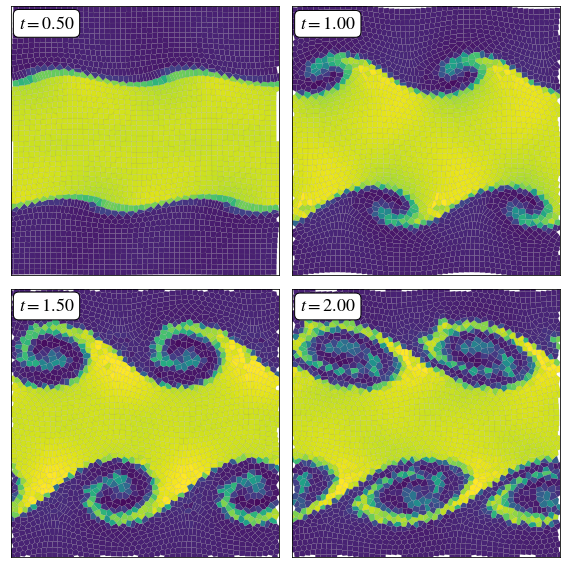

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import h5py

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16

reader = phd.Hdf5()
fig, axes = plt.subplots(2,2, figsize=(8,8))
file_names =["kelvin_output/time_interval/time_interval0004/time_interval0004.hdf5",
        "kelvin_output/time_interval/time_interval0009/time_interval0009.hdf5",
        "kelvin_output/time_interval/time_interval0014/time_interval0014.hdf5",
        "kelvin_output/final_output/final_output0000/final_output0000.hdf5"]

for i in range(2):
    for j in range(2):

        file_name = file_names[2*i + j]
        kelvin, units = reader.read(file_name)
        patch, colors = phd.vor_collection(kelvin, "density")
        kelvin.remove_tagged_particles(phd.ParticleTAGS.Ghost)

        time = h5py.File(file_name, "r").attrs["time"]

        p = PatchCollection(patch, edgecolor="gray", linewidth=0.1)
        p.set_array(np.array(colors))
        p.set_clim([0.9, 2.1])

        ax = axes[i, j]
        ax.text(0.03, 0.92, r"$t=%0.2f$" % time, fontsize=18,
                bbox=dict(boxstyle="round", facecolor="white"))
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.add_collection(p)
        ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("kelvin.png")
plt.show()